Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.286509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 597
[LightGBM] [Info] Number of data points in the train set: 775775, number of used features: 21
[LightGBM] [Info] Start training from score 0.504256


<ipython-input-2-bb8cafcee08b>:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_scores, y=mean_scores.index, orient='h', ax=ax, palette='husl')


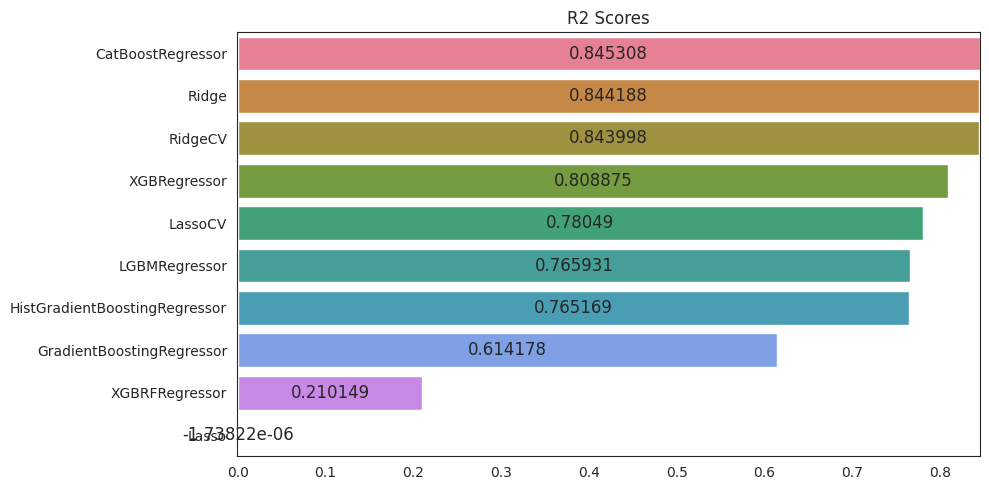

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from xgboost import XGBRFRegressor
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Function to load data from Google Drive
def load_data():
    train = pd.read_csv('/content/drive/My Drive/Colab/playground-series-s4e5/train_cleaned.csv')
    test = pd.read_csv('/content/drive/My Drive/Colab/playground-series-s4e5/test_cleaned.csv')
    return train, test

# Load data
train, test = load_data()

# Prepare the data
X = train.drop('FloodProbability', axis=1)
y = train['FloodProbability']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize models
xgb_model = XGBRegressor()
cb_model = CatBoostRegressor(verbose=0)
lgbm_model = LGBMRegressor()
hgb_model = HistGradientBoostingRegressor()
gb_model = GradientBoostingRegressor()
xgbrf_model = XGBRFRegressor()
ridge = Ridge()
ridge_cv = RidgeCV(alphas=[0.1, 1.0, 10.0])
lasso = Lasso()
lasso_cv = LassoCV()

models = [xgb_model, cb_model, lgbm_model, hgb_model, gb_model, xgbrf_model, ridge, ridge_cv, lasso, lasso_cv]
model_scores = {}

# Train models and collect R² scores
for model in models:
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    score = r2_score(y_val, y_val_pred)
    model_scores[model.__class__.__name__] = np.array([score] * 5)

# Create DataFrame with scores
scores = pd.DataFrame(model_scores)

# Sort by mean scores
scores = scores[scores.mean().sort_values(ascending=False).index]

# Plotting
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mean_scores = scores.mean().sort_values(ascending=False)
sns.barplot(x=mean_scores, y=mean_scores.index, orient='h', ax=ax, palette='husl')
ax.set_title('R2 Scores')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(mean_scores.min() - 0.001, mean_scores.max() + 0.0002)
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
## Save to CSV
#call the id column from the test data
ids = test['id']

# Combine ids and predictions into a structured array
combined_data = np.array(list(zip(ids, y_val_pred)), dtype=[('id', int), ('FloodProbability', int)])

# Define the header
header = 'id,FloodProbability'

# Save to CSV with header
np.savetxt('submission.csv', combined_data, delimiter=',', header=header, fmt='%d,%.2f', comments='')